<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/DSBiGRU/DSBiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch DSBiGRU https://github.com/ppkgtmm/emotion.git emotion

In [6]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, bigru
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [7]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Fixed('output_dim', 256)
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Fixed('gru_units', 64)
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words),
hp.Float('drop_rate', 0.1, 0.5, 0.1)
seed = 1234

In [8]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
17583,i am not always feeling creative,joy
4016,i feel funny about mothers day,surprise
13019,i get the feeling were being tortured,anger
9560,i feel a gentle amusement,love
12567,i feel about him and how he affects me and peo...,anger


In [10]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [11]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [12]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [13]:
tuner = BayesianOptimization( bigru.build_dstacked_bigru,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/dsbigru_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          123648    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,038,918
Trainable params: 4,038,918
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=3)

Trial 12 Complete [00h 04m 06s]
val_accuracy: 0.933529406785965

Best val_accuracy So Far: 0.9338235259056091
Total elapsed time: 00h 49m 27s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
output_dim (Fixed)
{'conditions': [], 'value': 256}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
gru_units (Fixed)
{'conditions': [], 'value': 64}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
drop_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [16]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/dsbigru_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
gru_units: 64
max_len: 300
num_words: 15000
drop_rate: 0.2
Score: 0.9338235259056091
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
gru_units: 64
max_len: 300
num_words: 15000
drop_rate: 0.1
Score: 0.9338235259056091
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
drop_rate: 0.5
Score: 0.933529406785965


In [23]:
best_model = tuner.get_best_models(num_models=2)[-1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          123648    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,038,918
Trainable params: 4,038,918
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
__________________________

94/94 [==============================] - 2s 19ms/step
Accuracy:	93.3%


              precision    recall  f1-score   support

       anger       0.97      0.90      0.93       406
        fear       0.84      0.94      0.89       356
         joy       0.95      0.94      0.95      1014
        love       0.86      0.85      0.86       246
     sadness       0.97      0.98      0.97       870
    surprise       0.88      0.75      0.81       108

    accuracy                           0.93      3000
   macro avg       0.91      0.89      0.90      3000
weighted avg       0.93      0.93      0.93      3000



<Figure size 432x288 with 0 Axes>

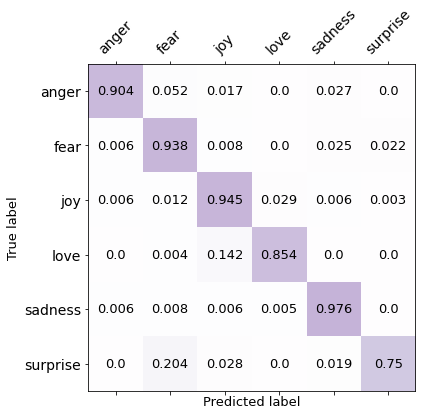

In [26]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [27]:
# best_model.save('model.h5')

In [28]:
# utils.dump(tokenizer, '/content/drive/MyDrive/__ed__/dsbigru_B32/tokenizer.pickle')

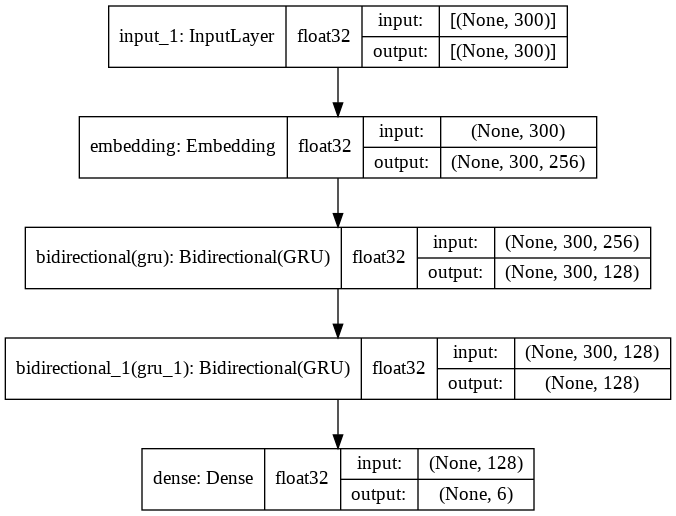

In [29]:
from keras.utils import plot_model
plot_model(
    best_model,
    to_file='/content/drive/MyDrive/__ed__/dsbigru_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )